<a href="https://colab.research.google.com/github/OJB-Quantum/Secondary-Ion-Mass-Spec-Analysis/blob/main/Ion_Probe_(SIMS)_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Extraction, Fitting, & Analysis of Secondary Ion Mass Spectrometry Performed on Thin Films During Ion Milling (Ion Beam Etching): By Onri Jay Benally

Before performing the script below, be sure to upload the image or experimental data to the notebook folder and replace the path link where applicable.
________________________________________________________________

The following plots are an attempt at extracting data points from an image or screenshot of the raw ion probe (secondary ion mass spectrometry) data shown during the ion milling etch process of a thin film. First a polynomial fitting curve is applied to the raw data for demonstration, followed by applying a moving average fitting curve on the raw data. At the end of the notebook, a Fourier transform is applied in an attempt to highlight the primary peaks in the data.

Note: For cleaner data plotting and analysis, one can download the real data from the ion probe equipment software (instead of a screenshot), which can be manually cleaned, filtered, or isolated per line. Subsequently, the fitting curves and Fourier transform can be applied on the cleaned up experimental data as needed.

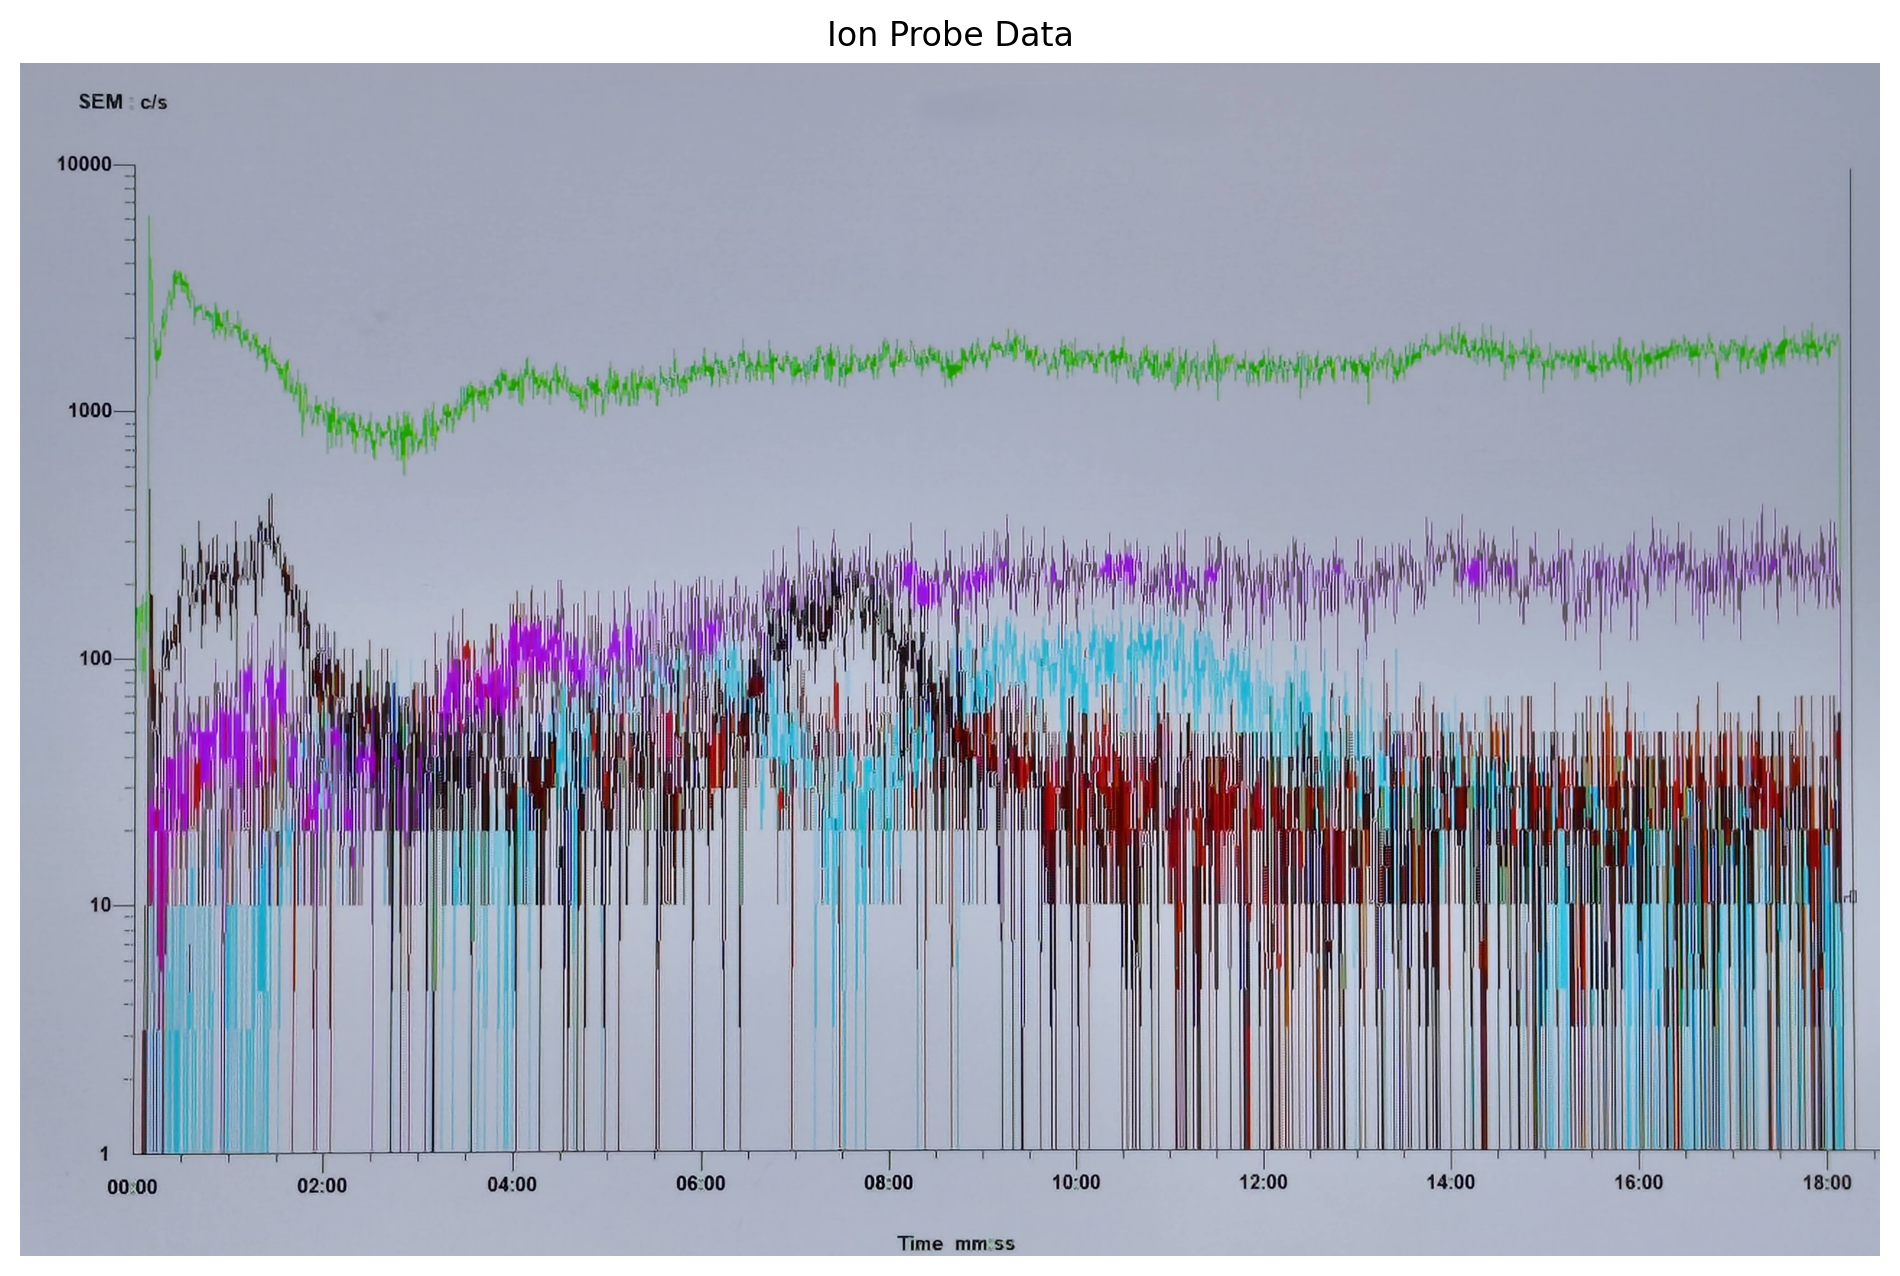

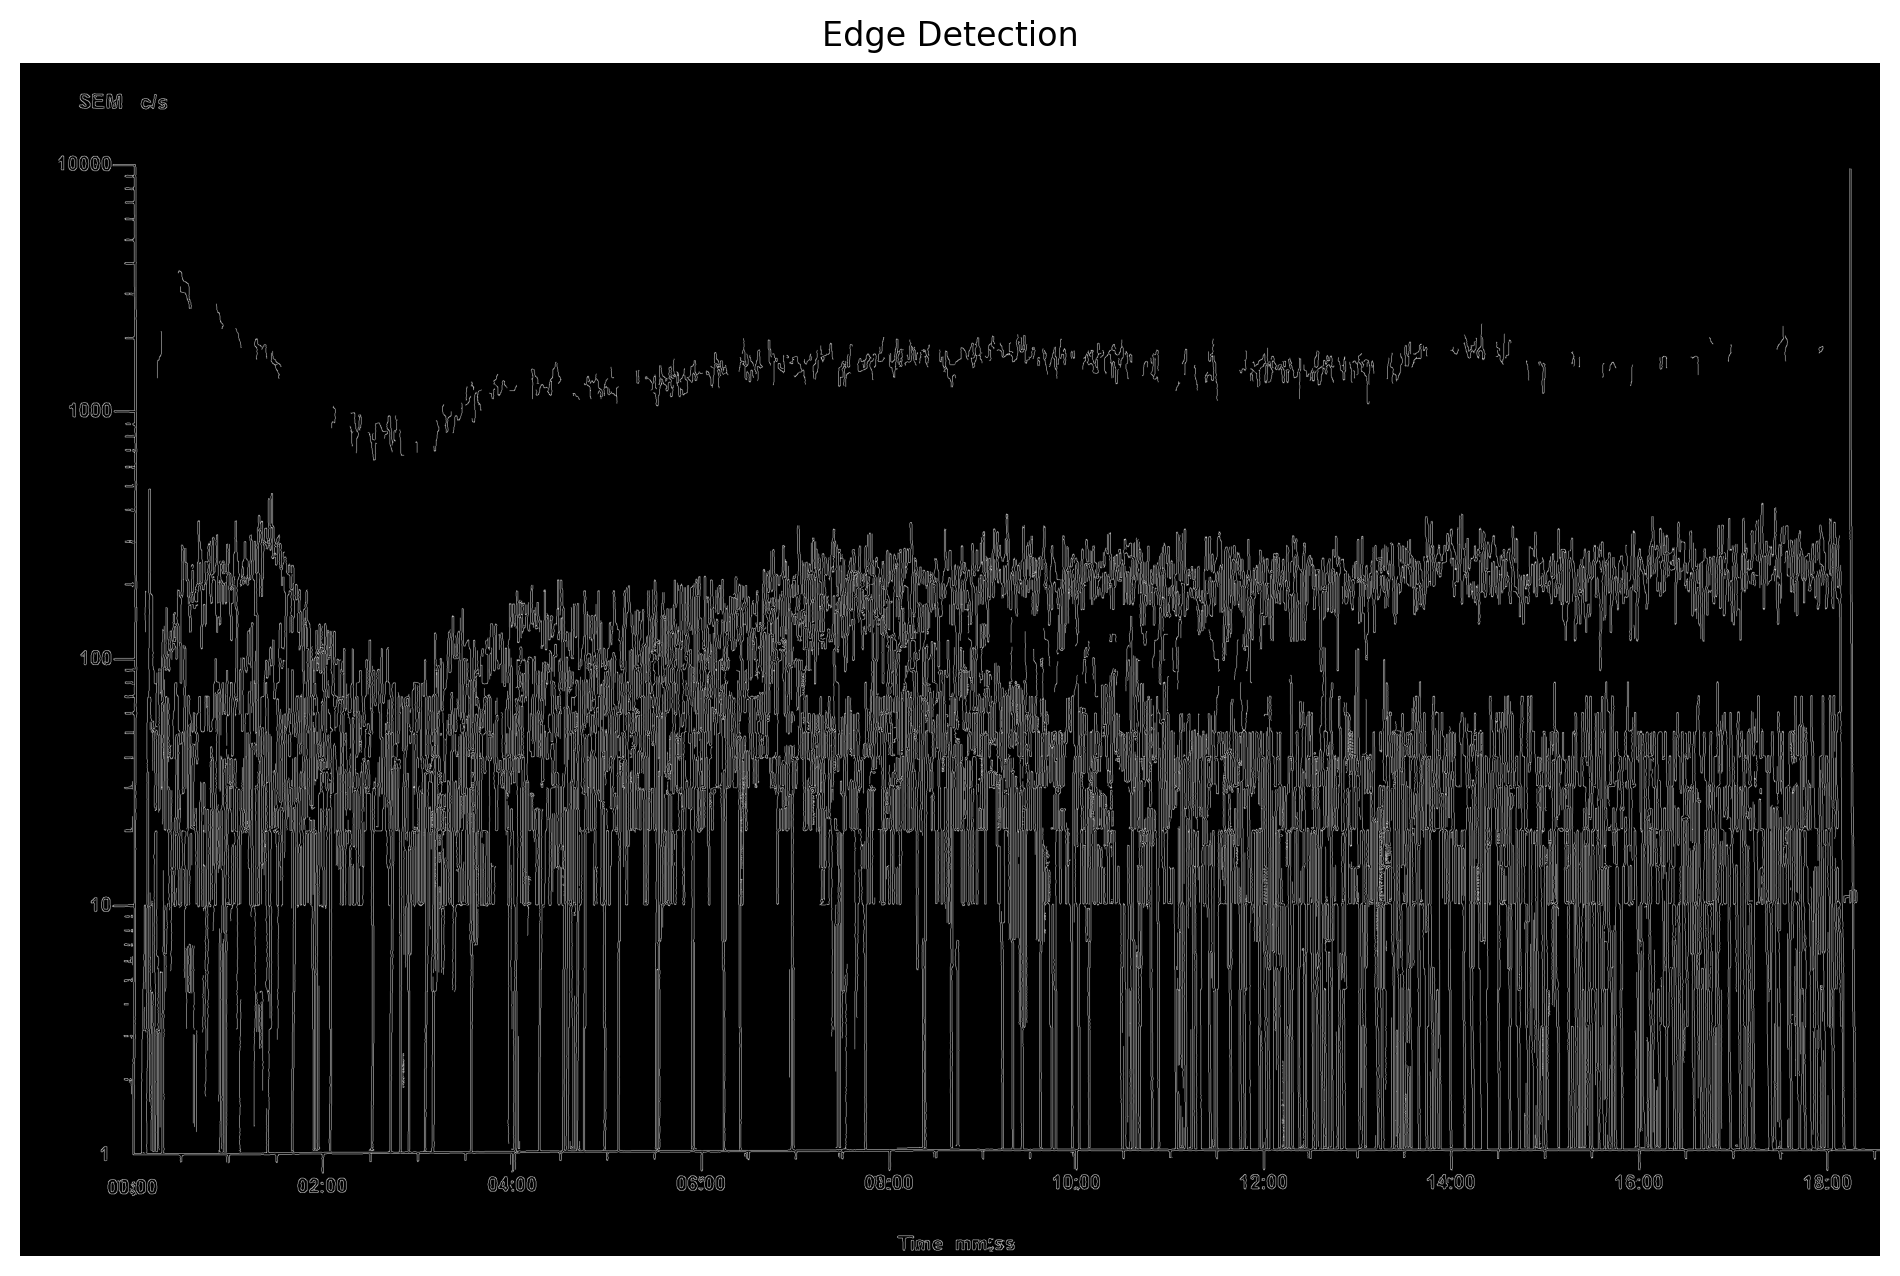

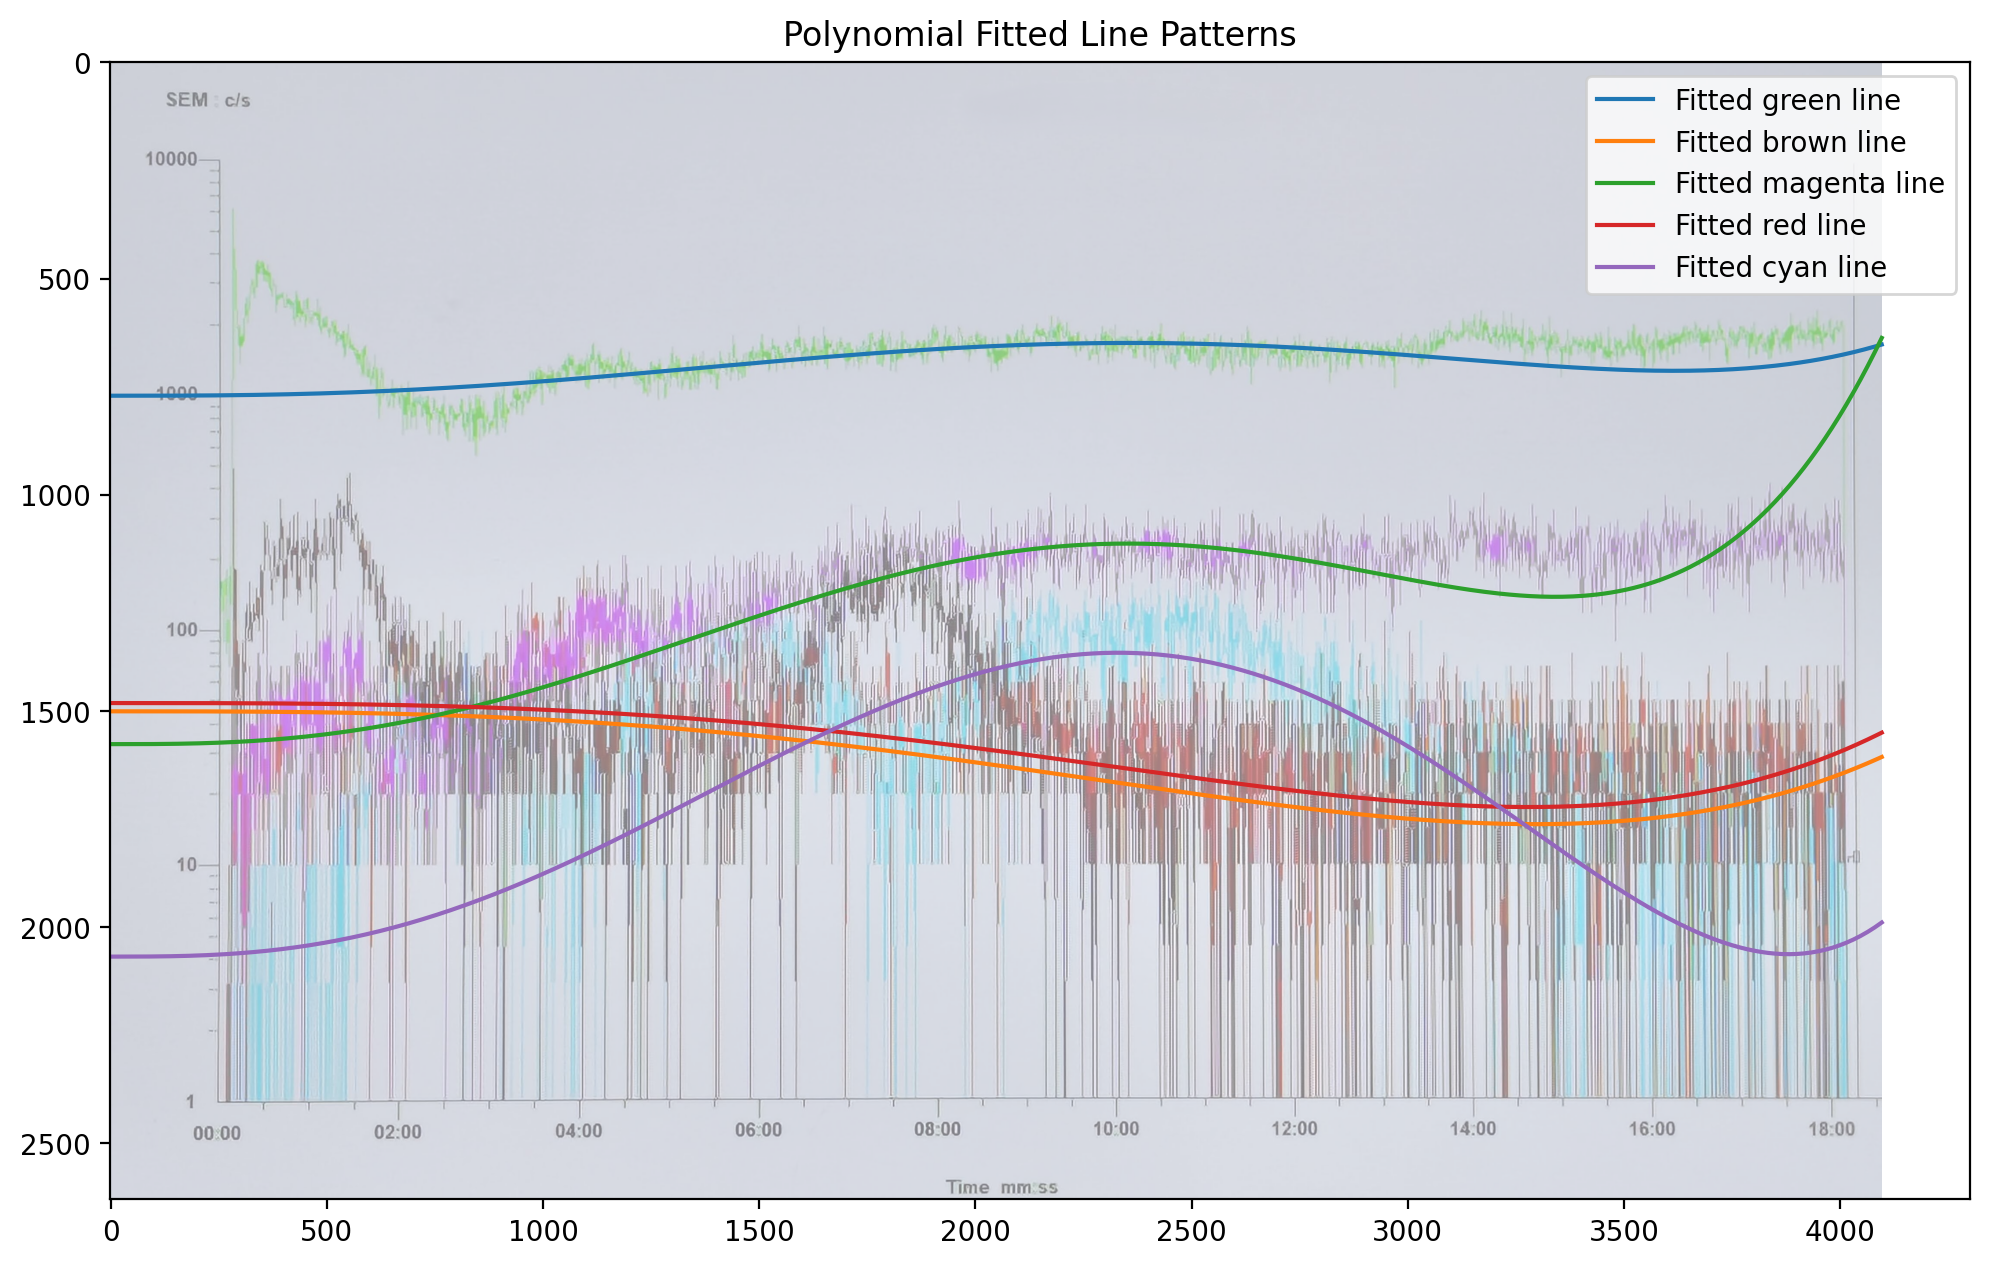

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Onri prefers using rcParams to increase the quality of all plots to be higher than the default settings.
# This only needs to be done once at beginning of every Jupyter Notebook.
plt.rcParams['figure.dpi'] = 200

# Load the image
image_path = '/content/Ion Probe Data.jpg'  # Updated file path
image = cv2.imread(image_path)

# Convert to RGB (for matplotlib compatibility)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title("Ion Probe Data")
plt.axis("off")
plt.show()

# Preprocess the image for line extraction (convert to grayscale and apply edge detection)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Display edges
plt.figure(figsize=(12, 8))
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection")
plt.axis("off")
plt.show()

# Define color ranges based on visual observation (green, brown, magenta, red, cyan)
color_ranges = {
    "green": ([0, 128, 0], [100, 255, 100]),
    "brown": ([50, 30, 10], [180, 100, 50]),
    "magenta": ([128, 0, 128], [255, 100, 255]),
    "red": ([128, 0, 0], [255, 100, 100]),
    "cyan": ([0, 128, 128], [100, 255, 255])
}

# Extract data points for each color pattern
color_data = {}
for color, (lower, upper) in color_ranges.items():
    lower_bound = np.array(lower, dtype=np.uint8)
    upper_bound = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(image_rgb, lower_bound, upper_bound)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point[0])
    if points:
        color_data[color] = np.array(points)

# Perform regression for each color pattern
fit_results = {}
x_vals = np.linspace(0, image.shape[1], num=500)  # Interpolated x-values for fitting
for color, points in color_data.items():
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]

    # Interpolation and regression
    poly_features = PolynomialFeatures(degree=5)
    x_poly = poly_features.fit_transform(x.reshape(-1, 1))
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(poly_features.transform(x_vals.reshape(-1, 1)))

    # Save results
    fit_results[color] = (x_vals, y_pred)

# Plot extracted and fitted data
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb, alpha=0.5)
for color, (x_fit, y_fit) in fit_results.items():
    plt.plot(x_fit, y_fit, label=f"Fitted {color} line")
plt.legend()
plt.title("Polynomial Fitted Line Patterns")
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


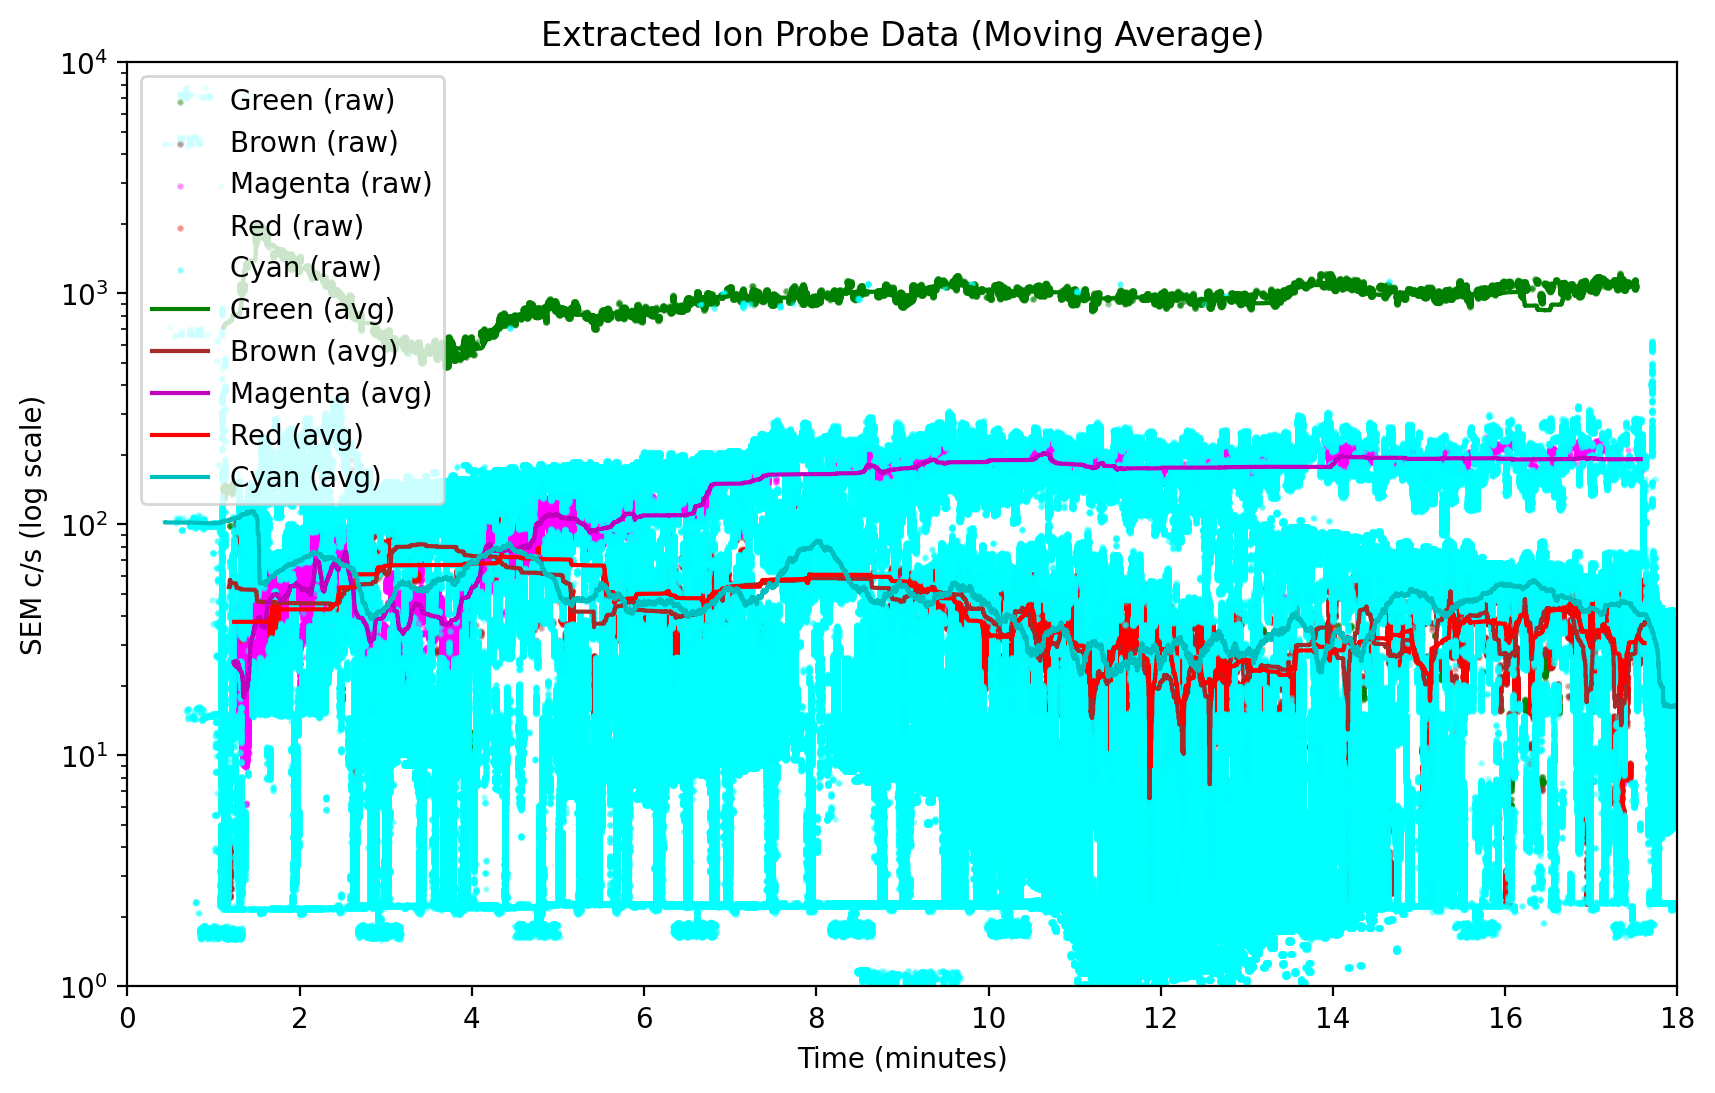

Approx. average BGR values for each color range (0..255):
 Green   : [ 43.52040978 153.69443418  55.81097851]
 Brown   : [ 50.01245057  57.28993103 111.008     ]
 Magenta : [173.17481266  38.97124584 137.98257262]
 Red     : [ 32.43282231  34.88881936 124.77509107]
 Cyan    : [214.94489734 197.59455587 196.51453284]


In [29]:
# If OpenCV isn't installed in your Colab environment, uncomment below:
# !pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d

###############################################################################
# 1. HELPER FUNCTIONS
###############################################################################

def extract_line_coordinates(img_bgr, lower_bgr, upper_bgr):
    """
    Create a mask for pixels whose BGR color lies in [lower_bgr, upper_bgr].
    Return list of (x, y) pixel coordinates for those pixels.
    """
    mask = cv2.inRange(img_bgr, lower_bgr, upper_bgr)
    points = cv2.findNonZero(mask)
    if points is None:
        return []
    # Convert from OpenCV's shape-of-interest to a simple list of (x, y)
    coords = [(pt[0][0], pt[0][1]) for pt in points]
    return coords

def pixel_to_data(
    x_px, y_px,
    width_px, height_px,
    x_min=0, x_max=18,    # Example: 00:00 to 18:00 on x-axis
    y_min=1, y_max=10000, # Example: SEM c/s from 1..10000 (log scale)
    is_log_scale=True
):
    """
    Naive mapping of image pixel (x_px, y_px) into approximate chart data coords.
    (Assumes entire image is the plotting region.)
    """
    # Convert pixel location to normalized [0..1] coordinates
    x_norm = x_px / float(width_px)
    # Flip y so top of image = y=0, bottom of image = y=1
    y_norm = 1.0 - (y_px / float(height_px))

    # Map x to time range
    data_x = x_min + x_norm * (x_max - x_min)

    # Map y to log-scale range
    if is_log_scale:
        # We'll interpret y_norm in log10 space between 1 and 10^4
        log_min = np.log10(y_min)
        log_max = np.log10(y_max)
        data_y_log = log_min + y_norm * (log_max - log_min)
        data_y = 10**data_y_log
    else:
        data_y = y_min + y_norm * (y_max - y_min)

    return data_x, data_y

def moving_average_smooth(xs, ys, window_frac=0.02):
    """
    Smooth 'ys' using uniform_filter1d, with window size as a fraction
    of the total length of ys. Return the same xs plus smoothed ys.
    """
    if len(ys) < 5:
        return xs, ys  # too few points to smooth meaningfully

    window_size = max(1, int(len(ys) * window_frac))
    ys_smooth = uniform_filter1d(ys, size=window_size)
    return xs, ys_smooth

def compute_average_bgr(img_bgr, lower_bgr, upper_bgr):
    """
    Given an image and a BGR color range, compute the average BGR
    in that masked region.
    """
    mask = cv2.inRange(img_bgr, lower_bgr, upper_bgr)
    masked_pixels = img_bgr[mask > 0]
    if len(masked_pixels) == 0:
        return None
    mean_bgr = np.mean(masked_pixels, axis=0)
    return mean_bgr

###############################################################################
# 2. MAIN PROCESSING FUNCTION
###############################################################################

def process_ion_probe_image(
    image_path="/content/Ion Probe Data.jpg",

    # You will need to tune these (B, G, R) ranges to best match your lines.
    # Below ranges are guesses that *may* capture the respective lines:
    lower_green   = (  0, 100,   0),
    upper_green   = ( 80, 255,  80),

    lower_brown   = ( 10,  40,  80),
    upper_brown   = ( 70, 100, 190),

    lower_magenta = (100,   0, 100),
    upper_magenta = (255,  80, 255),

    # Approx range for red lines (B, G, R)
    lower_red     = (  0,   0, 100),
    upper_red     = ( 80,  80, 255),

    lower_cyan    = (100, 180, 180),
    upper_cyan    = (255, 255, 255)
):
    # 1. Load the image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not load image at {image_path}")

    height, width, _ = img_bgr.shape

    # 2. Extract pixel coordinates by color
    green_pixels   = extract_line_coordinates(img_bgr, np.array(lower_green),   np.array(upper_green))
    brown_pixels   = extract_line_coordinates(img_bgr, np.array(lower_brown),   np.array(upper_brown))
    magenta_pixels = extract_line_coordinates(img_bgr, np.array(lower_magenta), np.array(upper_magenta))
    red_pixels     = extract_line_coordinates(img_bgr, np.array(lower_red),     np.array(upper_red))
    cyan_pixels    = extract_line_coordinates(img_bgr, np.array(lower_cyan),    np.array(upper_cyan))

    # 3. Convert pixel coords -> approximate data coords
    green_data   = [pixel_to_data(x, y, width, height) for (x,y) in green_pixels]
    brown_data   = [pixel_to_data(x, y, width, height) for (x,y) in brown_pixels]
    magenta_data = [pixel_to_data(x, y, width, height) for (x,y) in magenta_pixels]
    red_data     = [pixel_to_data(x, y, width, height) for (x,y) in red_pixels]
    cyan_data    = [pixel_to_data(x, y, width, height) for (x,y) in cyan_pixels]

    # 4. Sort data by x
    green_data.sort(key=lambda p: p[0])
    brown_data.sort(key=lambda p: p[0])
    magenta_data.sort(key=lambda p: p[0])
    red_data.sort(key=lambda p: p[0])
    cyan_data.sort(key=lambda p: p[0])

    # 5. Separate into x and y arrays
    gx, gy = zip(*green_data)   if len(green_data)   > 1 else ([], [])
    bx, by = zip(*brown_data)   if len(brown_data)   > 1 else ([], [])
    mx, my = zip(*magenta_data) if len(magenta_data) > 1 else ([], [])
    rx, ry = zip(*red_data)     if len(red_data)     > 1 else ([], [])
    cx, cy = zip(*cyan_data)    if len(cyan_data)    > 1 else ([], [])

    # 6. Apply moving-average smoothing
    gx_smooth, gy_smooth = moving_average_smooth(gx, gy)
    bx_smooth, by_smooth = moving_average_smooth(bx, by)
    mx_smooth, my_smooth = moving_average_smooth(mx, my)
    rx_smooth, ry_smooth = moving_average_smooth(rx, ry)
    cx_smooth, cy_smooth = moving_average_smooth(cx, cy)

    # 7. Average BGR color for each pattern
    green_avg_bgr   = compute_average_bgr(img_bgr, np.array(lower_green),   np.array(upper_green))
    brown_avg_bgr   = compute_average_bgr(img_bgr, np.array(lower_brown),   np.array(upper_brown))
    magenta_avg_bgr = compute_average_bgr(img_bgr, np.array(lower_magenta), np.array(upper_magenta))
    red_avg_bgr     = compute_average_bgr(img_bgr, np.array(lower_red),     np.array(upper_red))
    cyan_avg_bgr    = compute_average_bgr(img_bgr, np.array(lower_cyan),    np.array(upper_cyan))

    ###########################################################################
    # 3. PLOTTING
    ###########################################################################
    plt.figure(figsize=(10, 6))
    plt.title("Extracted Ion Probe Data (Moving Average)")

    # Scatter raw data
    if gx: plt.scatter(gx, gy, s=2, c='green',   alpha=0.3, label="Green (raw)")
    if bx: plt.scatter(bx, by, s=2, c='brown',   alpha=0.3, label="Brown (raw)")
    if mx: plt.scatter(mx, my, s=2, c='magenta', alpha=0.3, label="Magenta (raw)")
    if rx: plt.scatter(rx, ry, s=2, c='red',     alpha=0.3, label="Red (raw)")
    if cx: plt.scatter(cx, cy, s=2, c='cyan',    alpha=0.3, label="Cyan (raw)")

    # Plot smoothed curves
    if gx_smooth: plt.plot(gx_smooth, gy_smooth, '-g', label="Green (avg)")
    if bx_smooth: plt.plot(bx_smooth, by_smooth, '-', color='brown', label="Brown (avg)")
    if mx_smooth: plt.plot(mx_smooth, my_smooth, '-m', label="Magenta (avg)")
    if rx_smooth: plt.plot(rx_smooth, ry_smooth, '-r', label="Red (avg)")
    if cx_smooth: plt.plot(cx_smooth, cy_smooth, '-c', label="Cyan (avg)")

    plt.xlabel("Time (minutes)")
    plt.ylabel("SEM c/s (log scale)")
    plt.xlim(0, 18)    # example range
    plt.yscale("log")
    plt.ylim(1, 10000) # example range

    plt.legend()
    plt.show()

    ###########################################################################
    # 4. PRINT OUT AVERAGE COLORS
    ###########################################################################
    print("Approx. average BGR values for each color range (0..255):")
    print(" Green   :", green_avg_bgr)
    print(" Brown   :", brown_avg_bgr)
    print(" Magenta :", magenta_avg_bgr)
    print(" Red     :", red_avg_bgr)
    print(" Cyan    :", cyan_avg_bgr)

# Finally, call the main function (adjust the color thresholds as needed).
process_ion_probe_image("/content/Ion Probe Data.jpg")


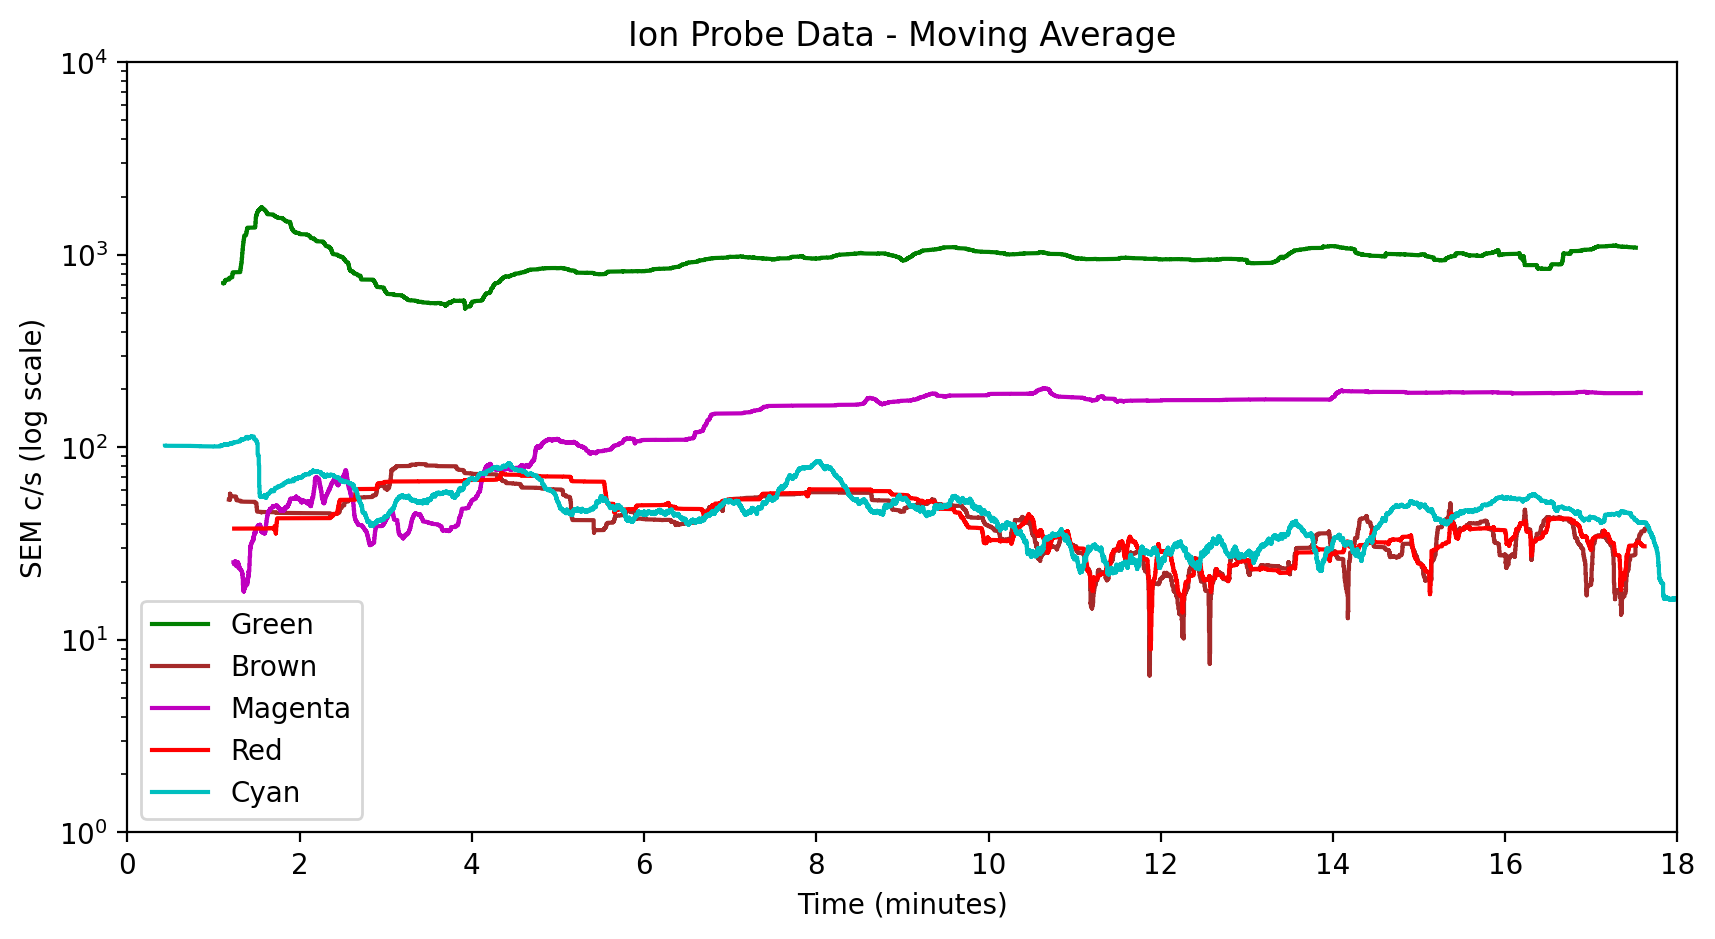

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


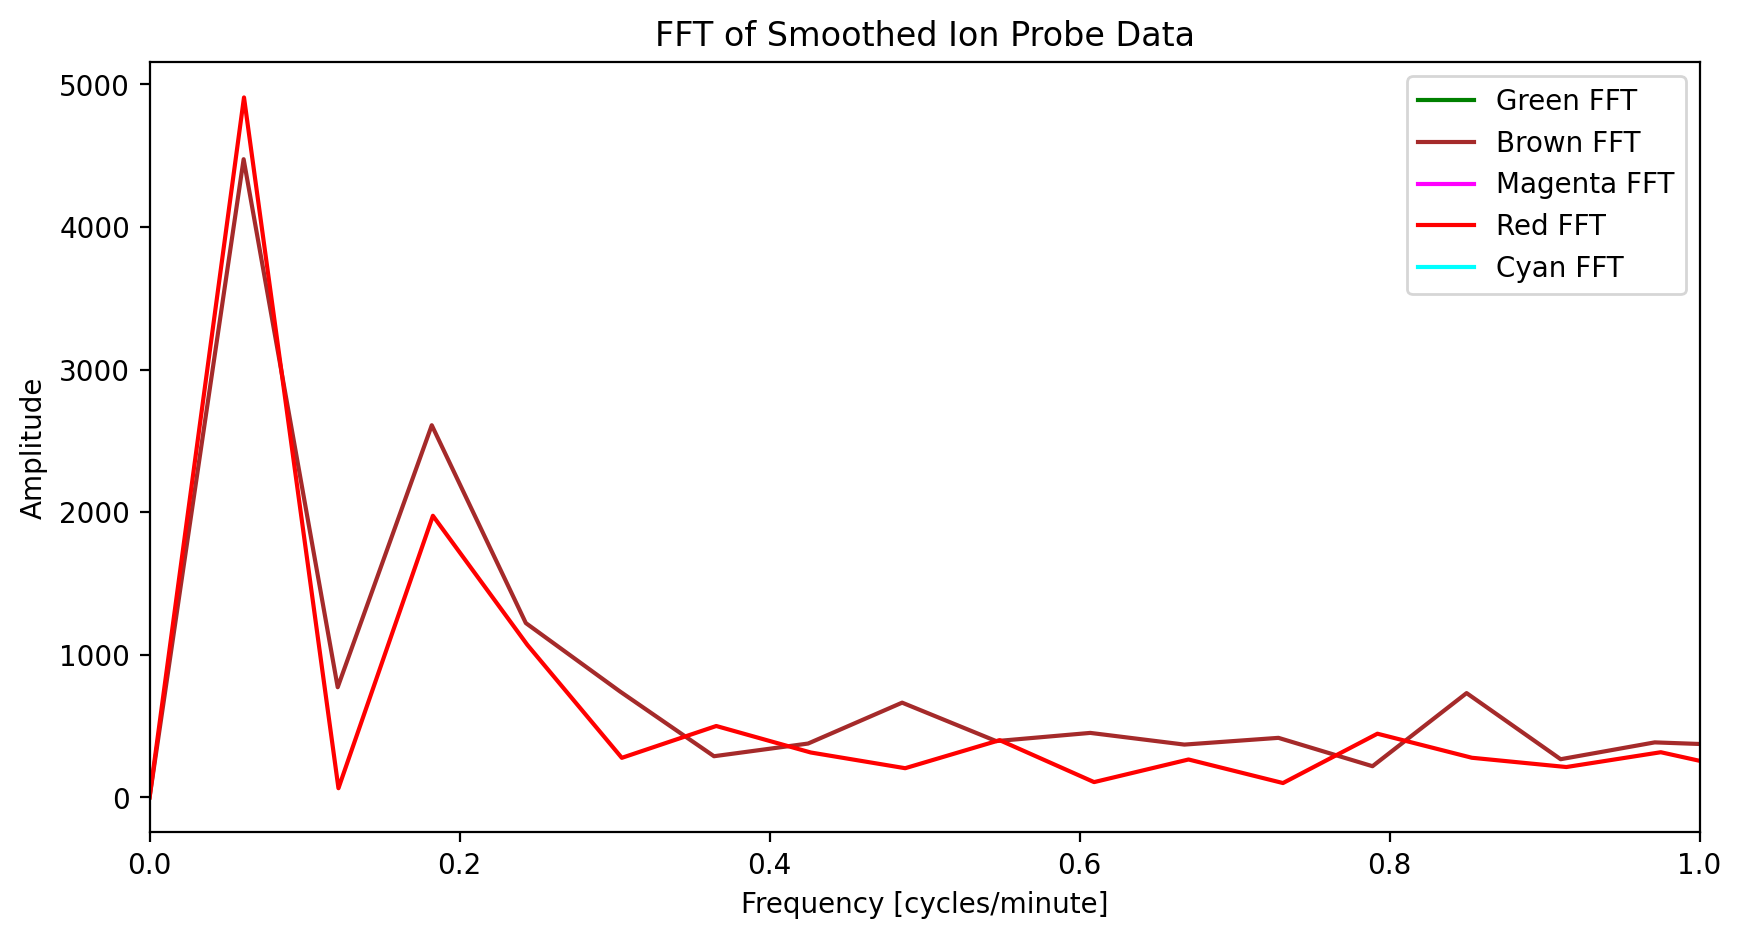

Approx. average BGR values (0..255) for each color range:
 Green   : [ 43.52040978 153.69443418  55.81097851]
 Brown   : [ 50.01245057  57.28993103 111.008     ]
 Magenta : [173.17481266  38.97124584 137.98257262]
 Red     : [ 32.43282231  34.88881936 124.77509107]
 Cyan    : [214.94489734 197.59455587 196.51453284]


In [30]:
# If OpenCV isn't installed yet in your Colab:
# !pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d

###############################################################################
# 1. HELPER FUNCTIONS
###############################################################################

def extract_line_coordinates(img_bgr, lower_bgr, upper_bgr):
    """
    Create a mask for pixels whose BGR color lies in [lower_bgr, upper_bgr].
    Return list of (x, y) pixel coordinates for those pixels.
    """
    mask = cv2.inRange(img_bgr, lower_bgr, upper_bgr)
    points = cv2.findNonZero(mask)
    if points is None:
        return []
    coords = [(pt[0][0], pt[0][1]) for pt in points]  # (x, y)
    return coords

def pixel_to_data(x_px, y_px, width_px, height_px,
                  x_min=0, x_max=18,    # minutes on the x-axis
                  y_min=1, y_max=10000, # SEM c/s from 1..10000 (log scale)
                  is_log_scale=True):
    """
    Naive mapping of image pixel (x_px, y_px) into approximate chart data coords.
    (Assumes entire image is the plotting region.)
    """
    x_norm = x_px / float(width_px)
    y_norm = 1.0 - (y_px / float(height_px))  # flip y

    data_x = x_min + x_norm * (x_max - x_min)

    if is_log_scale:
        log_min = np.log10(y_min)
        log_max = np.log10(y_max)
        data_y_log = log_min + y_norm * (log_max - log_min)
        data_y = 10**data_y_log
    else:
        data_y = y_min + y_norm * (y_max - y_min)

    return data_x, data_y

def moving_average_smooth(xs, ys, window_frac=0.02):
    """
    Smooth 'ys' using uniform_filter1d, with window size as a fraction
    of the total length of ys. Returns the same xs plus smoothed ys.
    """
    if len(ys) < 5:
        return xs, ys  # too few points to smooth

    window_size = max(1, int(len(ys) * window_frac))
    ys_smooth = uniform_filter1d(ys, size=window_size)
    return xs, ys_smooth

def compute_average_bgr(img_bgr, lower_bgr, upper_bgr):
    """
    Given an image and a BGR color range, compute the average BGR
    in that masked region.
    """
    mask = cv2.inRange(img_bgr, lower_bgr, upper_bgr)
    masked_pixels = img_bgr[mask > 0]
    if len(masked_pixels) == 0:
        return None
    mean_bgr = np.mean(masked_pixels, axis=0)
    return mean_bgr

def plot_fft(xs, ys, label='', color='k'):
    """
    1. Interpolate (xs, ys) onto a uniform time grid.
    2. Compute FFT.
    3. Plot amplitude spectrum (only positive frequencies).
    """
    if len(xs) < 2 or len(ys) < 2:
        return  # not enough data

    # Sort by x, just in case
    sorted_data = sorted(zip(xs, ys), key=lambda x: x[0])
    xs_sorted, ys_sorted = zip(*sorted_data)

    # Pick a uniform grid of, say, 512 points across the time range
    x_min, x_max = xs_sorted[0], xs_sorted[-1]
    if x_max <= x_min:
        return

    N = 512  # or 1024, etc.
    x_uniform = np.linspace(x_min, x_max, N)

    # Interpolate
    f_interp = interp1d(xs_sorted, ys_sorted, kind='linear', fill_value='extrapolate')
    y_uniform = f_interp(x_uniform)

    # Subtract mean (for a better look at frequency components)
    y_detrended = y_uniform - np.mean(y_uniform)

    # FFT
    fft_vals = np.fft.fft(y_detrended)
    freqs = np.fft.fftfreq(N, d=(x_uniform[1] - x_uniform[0]))

    # Plot only the positive half of the frequency spectrum
    half = N // 2
    freqs_pos = freqs[:half]
    fft_mag   = np.abs(fft_vals[:half])

    # Plot amplitude vs frequency
    plt.plot(freqs_pos, fft_mag, color=color, label=label)

###############################################################################
# 2. MAIN PROCESSING FUNCTION
###############################################################################

def process_ion_probe_image(
    image_path="/content/Ion Probe Data.jpg",

    # Adjust these color thresholds as needed
    lower_green   = (  0, 100,   0),
    upper_green   = ( 80, 255,  80),

    lower_brown   = ( 10,  40,  80),
    upper_brown   = ( 70, 100, 190),

    lower_magenta = (100,   0, 100),
    upper_magenta = (255,  80, 255),

    lower_red     = (  0,   0, 100),
    upper_red     = ( 80,  80, 255),

    lower_cyan    = (100, 180, 180),
    upper_cyan    = (255, 255, 255)
):
    # 1. Load the image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")

    height, width, _ = img_bgr.shape

    # 2. Extract pixel coordinates by color
    green_pixels   = extract_line_coordinates(img_bgr, np.array(lower_green),   np.array(upper_green))
    brown_pixels   = extract_line_coordinates(img_bgr, np.array(lower_brown),   np.array(upper_brown))
    magenta_pixels = extract_line_coordinates(img_bgr, np.array(lower_magenta), np.array(upper_magenta))
    red_pixels     = extract_line_coordinates(img_bgr, np.array(lower_red),     np.array(upper_red))
    cyan_pixels    = extract_line_coordinates(img_bgr, np.array(lower_cyan),    np.array(upper_cyan))

    # 3. Convert pixel coords -> approximate data coords
    green_data   = [pixel_to_data(x, y, width, height) for (x,y) in green_pixels]
    brown_data   = [pixel_to_data(x, y, width, height) for (x,y) in brown_pixels]
    magenta_data = [pixel_to_data(x, y, width, height) for (x,y) in magenta_pixels]
    red_data     = [pixel_to_data(x, y, width, height) for (x,y) in red_pixels]
    cyan_data    = [pixel_to_data(x, y, width, height) for (x,y) in cyan_pixels]

    # 4. Sort data by x
    green_data.sort(key=lambda p: p[0])
    brown_data.sort(key=lambda p: p[0])
    magenta_data.sort(key=lambda p: p[0])
    red_data.sort(key=lambda p: p[0])
    cyan_data.sort(key=lambda p: p[0])

    # 5. Separate x & y, then do moving-average
    def get_smoothed_xy(data):
        if len(data) < 2:
            return [], []
        xs, ys = zip(*data)
        xs_smooth, ys_smooth = moving_average_smooth(xs, ys, window_frac=0.02)
        return xs_smooth, ys_smooth

    gx, gy = get_smoothed_xy(green_data)
    bx, by = get_smoothed_xy(brown_data)
    mx, my = get_smoothed_xy(magenta_data)
    rx, ry = get_smoothed_xy(red_data)
    cx, cy = get_smoothed_xy(cyan_data)

    # 6. Plot the smoothed data in time domain
    plt.figure(figsize=(10, 5))
    plt.title("Ion Probe Data - Moving Average")
    if gx: plt.plot(gx, gy, '-g', label='Green')
    if bx: plt.plot(bx, by, '-', color='brown', label='Brown')
    if mx: plt.plot(mx, my, '-m', label='Magenta')
    if rx: plt.plot(rx, ry, '-r', label='Red')
    if cx: plt.plot(cx, cy, '-c', label='Cyan')

    plt.xlabel("Time (minutes)")
    plt.ylabel("SEM c/s (log scale)")
    plt.yscale("log")
    plt.xlim(0, 18)       # Example
    plt.ylim(1, 10000)    # Example
    plt.legend()
    plt.show()

    # 7. Plot the Fourier transforms of the smoothed data
    plt.figure(figsize=(10, 5))
    plt.title("FFT of Smoothed Ion Probe Data")
    if gx: plot_fft(gx, gy, label='Green FFT',   color='green')
    if bx: plot_fft(bx, by, label='Brown FFT',   color='brown')
    if mx: plot_fft(mx, my, label='Magenta FFT', color='magenta')
    if rx: plot_fft(rx, ry, label='Red FFT',     color='red')
    if cx: plot_fft(cx, cy, label='Cyan FFT',    color='cyan')

    plt.xlabel("Frequency [cycles/minute]")
    plt.ylabel("Amplitude")
    plt.xlim(0, 1)  # Typically, you only show up to Nyquist (~ half of 1/dt)
    plt.legend()
    plt.show()

    # 8. Print the average BGR colors
    green_avg_bgr   = compute_average_bgr(img_bgr, np.array(lower_green),   np.array(upper_green))
    brown_avg_bgr   = compute_average_bgr(img_bgr, np.array(lower_brown),   np.array(upper_brown))
    magenta_avg_bgr = compute_average_bgr(img_bgr, np.array(lower_magenta), np.array(upper_magenta))
    red_avg_bgr     = compute_average_bgr(img_bgr, np.array(lower_red),     np.array(upper_red))
    cyan_avg_bgr    = compute_average_bgr(img_bgr, np.array(lower_cyan),    np.array(upper_cyan))

    print("Approx. average BGR values (0..255) for each color range:")
    print(" Green   :", green_avg_bgr)
    print(" Brown   :", brown_avg_bgr)
    print(" Magenta :", magenta_avg_bgr)
    print(" Red     :", red_avg_bgr)
    print(" Cyan    :", cyan_avg_bgr)

# Finally, call the main function:
process_ion_probe_image("/content/Ion Probe Data.jpg")
